In [24]:
from ensemble_boxes import *
import json
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [25]:
json1_path = r'/media/alvinai/Documents/underwater/ahf_work_dirs/ensemble_test/.json' # 模型1结果文件路径
json2_path = r'/media/alvinai/Documents/underwater/ahf_work_dirs/ensemble_test/.json' # 模型2结果文件路径
test_path = r'/media/alvinai/Documents/underwater/data/seacoco/testB.json' # 测试集标注路径
save_path = r'/media/alvinai/Documents/underwater/ahf_work_dirs/ensemble_test/ensemble_r101_r50.bbox.json' # 融合结果保存路径

In [26]:
with open(json1_path, 'r') as f1:
    json1 = json.load(f1)

with open(json2_path, 'r') as f2:
    json2 = json.load(f2)
    
with open(test_path, 'r') as f3:
    test = json.load(f3)

### 观察预测结果的内容

In [27]:
print(test['categories'])
print(json1[0])
print(json2[0])
print("="*20)
print("the number of annotations from json1:", len(json1))
cat_dict = {}
for i in range(1,6):
    if i not in list(cat_dict.keys()):
        cat_dict[i] = 0
for a in json1:
    cat_dict[a['category_id']]+=1
print(cat_dict)
print("="*20)
print("the number of annotations from json2:", len(json2))
cat_dict = {}
for i in range(1,6):
    if i not in list(cat_dict.keys()):
        cat_dict[i] = 0
for a in json2:
    cat_dict[a['category_id']]+=1
print(cat_dict)

[{'supercategory': 'holothurian', 'id': 1, 'name': 'holothurian'}, {'supercategory': 'echinus', 'id': 2, 'name': 'echinus'}, {'supercategory': 'scallop', 'id': 3, 'name': 'scallop'}, {'supercategory': 'starfish', 'id': 4, 'name': 'starfish'}]
{'image_id': 1, 'bbox': [371.8673095703125, 671.5302124023438, 185.91839599609375, 139.59893798828125], 'score': 0.9701465368270874, 'category_id': 1}
{'image_id': 1, 'bbox': [372.8462829589844, 672.221435546875, 185.55545043945312, 135.497314453125], 'score': 0.863899827003479, 'category_id': 1}
the number of annotations from json1: 240720
{1: 55041, 2: 64597, 3: 69668, 4: 51414, 5: 0}
the number of annotations from json2: 756983
{1: 200713, 2: 194420, 3: 185591, 4: 176259, 5: 0}


### 去除预测文件中的海草

In [28]:
json1_new = []
json2_new = []

def remove_waterweeds(old_json, new_json):
    """去除海草"""
    for a in old_json:
        if a['category_id'] != 5:
            new_json.append(a)

remove_waterweeds(json1, json1_new)
remove_waterweeds(json2, json2_new)
print('After removing waterweeds:')
print("the number of annotations from json1:", len(json1_new))
print("the number of annotations from json2:", len(json2_new))
json1 = json1_new
json2 = json2_new

After removing waterweeds:
the number of annotations from json1: 240720
the number of annotations from json2: 756983


### 定义单张图上的结果融合操作

In [29]:
def wbf(iou_thr, imgid, test, weights, skip_box_thr, conf_type):
    """对单张图上多个模型的结果进行融合
    参数：
        1. iou_thr(float)  : 设IOU多少才能实现boxes匹配，论文推荐0.55。
        2. imgid(int)      : 输入单张图片的image id。
        3. test(dict)      ：test.json文件的内容。
        4. weights(list)   : 给予分别给两个模型结果的权重，默认为[2, 1]，即模型1的box的权重为2，模型2的权重为1。
        5. skip_box_thr(float): 不对置信度小于kip_box_thr的框进行WBF。
        6. conf_type(str)  : 对于聚类匹配框的置信度采用的融合模式，‘avg'/’max‘。
    返回：
        1. boxes(list)     ：WBF融合后的框(从normalization恢复)，[x1, y1, w, h]。
        2. socres(list)    : WBF融合后的分数。
        3. labels(list)    : WBF融合后的标签。
    """
    # 获取该图的宽高
    imgw = None
    imgh = None
    for i in test['images']:
        if i['id'] == imgid:
            imgw = i['width']
            imgh = i['height']
            break
    
    # 用宽高normalize标注框
    boxes_list1 = []
    scores_list1 = []
    labels_list1 = []
    for a in json1:
        if a['image_id'] == imgid:
            bbox_x1 = float(a['bbox'][0] / imgw)
            bbox_y1 = float(a['bbox'][1] / imgh)
            bbox_x2 = float((a['bbox'][0] + a['bbox'][2] - 1) / imgw)
            bbox_y2 = float((a['bbox'][1] + a['bbox'][3] - 1) / imgh)
            boxes_list1.append([bbox_x1, bbox_y1, bbox_x2, bbox_y2])
            scores_list1.append(a['score'])
            labels_list1.append(a['category_id'])
            
    boxes_list2 = []
    scores_list2 = []
    labels_list2 = []
    for a in json2:
        if a['image_id'] == imgid:
            bbox_x1 = float(a['bbox'][0] / imgw)
            bbox_y1 = float(a['bbox'][1] / imgh)
            bbox_x2 = float((a['bbox'][0] + a['bbox'][2] - 1) / imgw)
            bbox_y2 = float((a['bbox'][1] + a['bbox'][3] - 1) / imgh)
            boxes_list2.append([bbox_x1, bbox_y1, bbox_x2, bbox_y2])
            scores_list2.append(a['score'])
            labels_list2.append(a['category_id'])            
            
    # 合并结果
    boxes_list = [boxes_list1, boxes_list2]
    scores_list = [scores_list1, scores_list2]
    labels_list = [labels_list1, labels_list2]
    
    # 实现weight boxes fusion
    boxes, scores, labels = weighted_boxes_fusion(boxes_list,
                                                  scores_list,
                                                  labels_list,
                                                  weights=weights,
                                                  iou_thr=iou_thr,
                                                  skip_box_thr=skip_box_thr,
                                                  conf_type=conf_type)

    # 还原normalized的bbox
    new_boxes = []
    for i, box in enumerate(boxes):
        box_x1 = float(box[0] * imgw)
        box_y1 = float(box[1] * imgh)
        box_w = float((box[2] - box[0]) * imgw)
        box_h = float((box[3] - box[1]) * imgh)
        new_boxes.append([box_x1, box_y1, box_w, box_h])
    return new_boxes, list(scores), list(labels)

### 批量对所有图的结果进行WBF

In [30]:
# 得到所有image_id
imgids = []
for r in test['images']:
    if r['id'] not in imgids:
        imgids.append(r['id'])
print("There are %d unique image id" % len(imgids))

There are 800 unique image id


In [31]:
iou_thr = 0.7
weights = [1, 1]
skip_box_thr = 0.0
conf_type = 'avg'

new_result = []
for imgid in tqdm(imgids):
    boxes, scores, labels = wbf(iou_thr, imgid, test, weights, skip_box_thr, conf_type)
    for i in range(len(boxes)):
        result = {'image_id':imgid,
                 'bbox':boxes[i],
                 'score':scores[i],
                 'category_id':int(labels[i])}
        new_result.append(result)
    
with open(save_path, 'w') as f4:
    json.dump(new_result, f4)




  0%|          | 0/800 [00:00<?, ?it/s]


  0%|          | 1/800 [00:00<06:00,  2.22it/s]


  0%|          | 2/800 [00:00<05:24,  2.46it/s]


  0%|          | 3/800 [00:01<05:36,  2.37it/s]


  0%|          | 4/800 [00:01<05:47,  2.29it/s]


  1%|          | 5/800 [00:01<05:18,  2.50it/s]


  1%|          | 6/800 [00:02<04:50,  2.73it/s]


  1%|          | 7/800 [00:02<04:49,  2.74it/s]


  1%|          | 8/800 [00:03<05:33,  2.37it/s]


  1%|          | 9/800 [00:03<05:52,  2.24it/s]


  1%|▏         | 10/800 [00:04<05:18,  2.48it/s]


  1%|▏         | 11/800 [00:04<05:11,  2.54it/s]


  2%|▏         | 12/800 [00:04<04:37,  2.84it/s]


  2%|▏         | 13/800 [00:05<04:58,  2.64it/s]


  2%|▏         | 14/800 [00:05<05:29,  2.39it/s]


  2%|▏         | 15/800 [00:05<04:56,  2.65it/s]


  2%|▏         | 16/800 [00:06<06:58,  1.87it/s]


  2%|▏         | 17/800 [00:07<07:17,  1.79it/s]


  2%|▏         | 18/800 [00:07<07:17,  1.79it/s]


  2%|▏         | 19/800 [00:08<07:58,  1.63it/

 34%|███▍      | 270/800 [01:54<03:14,  2.73it/s]


 34%|███▍      | 271/800 [01:54<03:24,  2.59it/s]


 34%|███▍      | 272/800 [01:55<03:31,  2.49it/s]


 34%|███▍      | 273/800 [01:55<03:24,  2.58it/s]


 34%|███▍      | 274/800 [01:56<03:18,  2.65it/s]


 34%|███▍      | 275/800 [01:56<03:11,  2.74it/s]


 34%|███▍      | 276/800 [01:56<03:11,  2.73it/s]


 35%|███▍      | 277/800 [01:57<02:59,  2.91it/s]


 35%|███▍      | 278/800 [01:57<02:59,  2.91it/s]


 35%|███▍      | 279/800 [01:57<03:09,  2.75it/s]


 35%|███▌      | 280/800 [01:58<03:21,  2.58it/s]


 35%|███▌      | 281/800 [01:58<03:29,  2.47it/s]


 35%|███▌      | 282/800 [01:59<03:26,  2.50it/s]


 35%|███▌      | 283/800 [01:59<03:37,  2.37it/s]


 36%|███▌      | 284/800 [01:59<03:39,  2.35it/s]


 36%|███▌      | 285/800 [02:00<03:45,  2.28it/s]


 36%|███▌      | 286/800 [02:00<03:50,  2.23it/s]


 36%|███▌      | 287/800 [02:01<03:50,  2.23it/s]


 36%|███▌      | 288/800 [02:01<04:07,  2.07it/s]


 36%|███▌   

 67%|██████▋   | 538/800 [04:18<02:33,  1.70it/s]


 67%|██████▋   | 539/800 [04:18<02:21,  1.85it/s]


 68%|██████▊   | 540/800 [04:18<02:05,  2.07it/s]


 68%|██████▊   | 541/800 [04:19<02:01,  2.14it/s]


 68%|██████▊   | 542/800 [04:19<01:57,  2.20it/s]


 68%|██████▊   | 543/800 [04:20<01:46,  2.41it/s]


 68%|██████▊   | 544/800 [04:20<01:59,  2.13it/s]


 68%|██████▊   | 545/800 [04:21<02:10,  1.95it/s]


 68%|██████▊   | 546/800 [04:21<02:12,  1.92it/s]


 68%|██████▊   | 547/800 [04:22<02:10,  1.94it/s]


 68%|██████▊   | 548/800 [04:22<02:05,  2.00it/s]


 69%|██████▊   | 549/800 [04:23<01:53,  2.21it/s]


 69%|██████▉   | 550/800 [04:23<01:54,  2.19it/s]


 69%|██████▉   | 551/800 [04:23<01:48,  2.31it/s]


 69%|██████▉   | 552/800 [04:24<01:49,  2.27it/s]


 69%|██████▉   | 553/800 [04:24<01:55,  2.13it/s]


 69%|██████▉   | 554/800 [04:25<01:46,  2.31it/s]


 69%|██████▉   | 555/800 [04:25<01:43,  2.36it/s]


 70%|██████▉   | 556/800 [04:26<01:44,  2.34it/s]


 70%|██████▉

In [32]:
cat_dict = {}
for i in range(1,5):
    if i not in list(cat_dict.keys()):
        cat_dict[i] = 0
for a in new_result:
    cat_dict[a['category_id']]+=1
print(cat_dict)

{1: 195034, 2: 177030, 3: 161006, 4: 169007}


In [33]:
test['images'][-1]

{'file_name': '000800.jpg', 'id': 800, 'width': 1920, 'height': 1080}

In [34]:
new_result[-1]

{'image_id': 800,
 'bbox': [827.8409423828125,
  1046.243896484375,
  58.814453124999986,
  32.326660156250085],
 'score': 5.03080191265326e-05,
 'category_id': 4}

In [35]:
print('After WBF:')
print("the number of annotation result:", len(new_result))

After WBF:
the number of annotation result: 702077


### 可视化结果（Debug用）

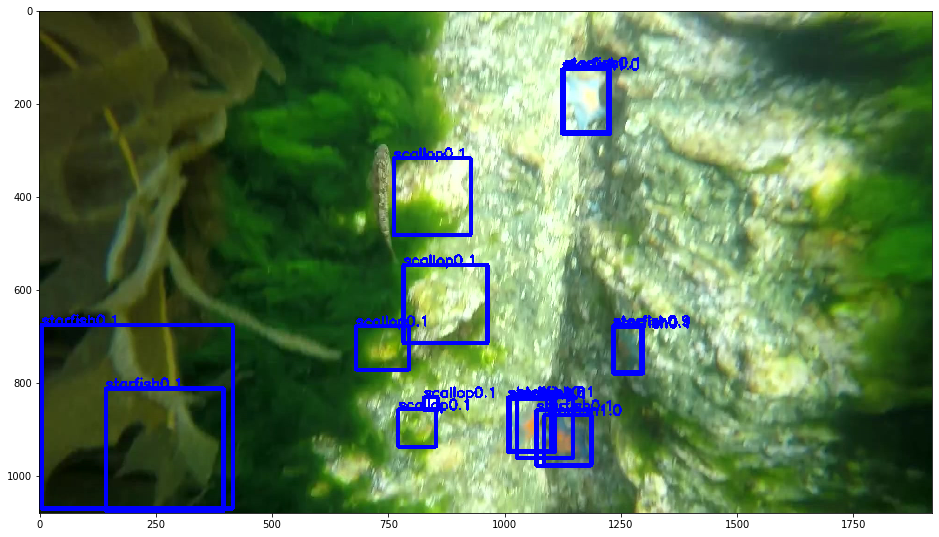

In [36]:
# 可视化模型1的结果
fig = plt.figure(figsize=(16,16))
img_path = r'/media/alvinai/Documents/underwater/data/seacoco/test/000800.jpg'
img = cv2.imread(img_path)
for a in json1:
    if a['image_id'] == 800 and a['score']>=0.05:
        boxes = a['bbox']
        img = cv2.rectangle(img, (int(boxes[0]), int(boxes[1])),
                            (int(boxes[0]+boxes[2]), int(boxes[1]+boxes[3])), (255,0,0), 8)
        for cat in test['categories']:
            if cat['id'] == a['category_id']:
                catname = cat['name']
                break
        txt = catname + str(round(a['score'],1))
        img = cv2.putText(img, txt, (int(boxes[0]), int(boxes[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 4)
plt.imshow(img[:,:,::-1])
plt.show()   

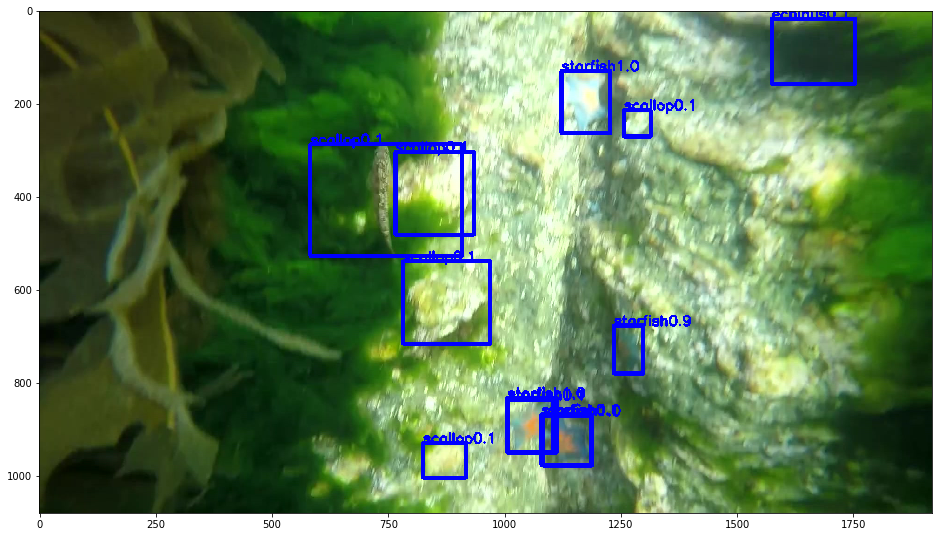

In [37]:
# 可视化模型2的结果
fig = plt.figure(figsize=(16,16))
img_path = r'/media/alvinai/Documents/underwater/data/seacoco/test/000800.jpg'
img = cv2.imread(img_path)
for a in json2:
    if a['image_id'] == 800 and a['score']>=0.05:
        boxes = a['bbox']
        img = cv2.rectangle(img, (int(boxes[0]), int(boxes[1])),
                            (int(boxes[0]+boxes[2]), int(boxes[1]+boxes[3])), (255,0,0), 8)
        for cat in test['categories']:
            if cat['id'] == a['category_id']:
                catname = cat['name']
                break
        txt = catname + str(round(a['score'],1))
        img = cv2.putText(img, txt, (int(boxes[0]), int(boxes[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 4)
plt.imshow(img[:,:,::-1])
plt.show()   

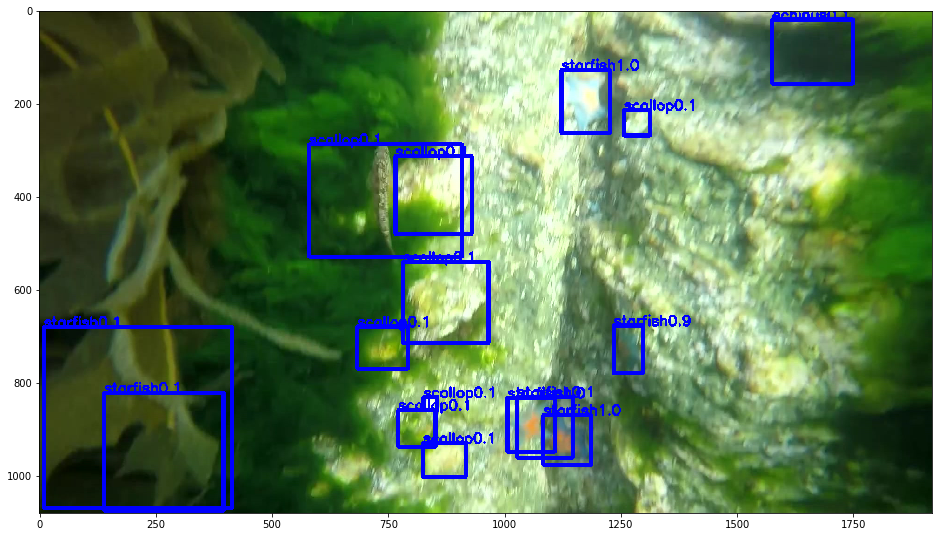

In [38]:
# 可视化模型2的结果
fig = plt.figure(figsize=(16,16))
img_path = r'/media/alvinai/Documents/underwater/data/seacoco/test/000800.jpg'
img = cv2.imread(img_path)
for a in new_result:
    if a['image_id'] == 800 and a['score']>=0.05:
        boxes = a['bbox']
        img = cv2.rectangle(img, (int(boxes[0]), int(boxes[1])),
                            (int(boxes[0]+boxes[2]), int(boxes[1]+boxes[3])), (255,0,0), 8)
        for cat in test['categories']:
            if cat['id'] == a['category_id']:
                catname = cat['name']
                break
        txt = catname + str(round(a['score'],1))
        img = cv2.putText(img, txt, (int(boxes[0]), int(boxes[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 4)
plt.imshow(img[:,:,::-1])
plt.show()   